# Logistic Regression
**Recitation by Dr. Duygu Ataman**

_02/23/2024, 09:30, 14:00 at Room 150_

_02/23/2024, 10:45, 13:30 Office Hours at Room 524 (For any follow-up questions)_

In these lab sessions, we will be using Jupyter notebooks running on Google Colab, which has most Python libraries installed.

Please open the IPython notebook in the folder. This notebook aims to introduce logistic regression models using PyTorch and pandas libraries in the weather forecasting application.

## Weather prediction

Previous recitation introduced the elements of a traditional machine learning pipeline through a weather forecasting application in Python. The data set of weather recordings from New York City is collected from [Open-Meteo](https://open-meteo.com/) between 2016 to 2022 in the column-separated file 'NYC_Weather_2016_2022.csv'.

We will start by allowing our application access to our local Google drives so files can be loaded into our Python programs.

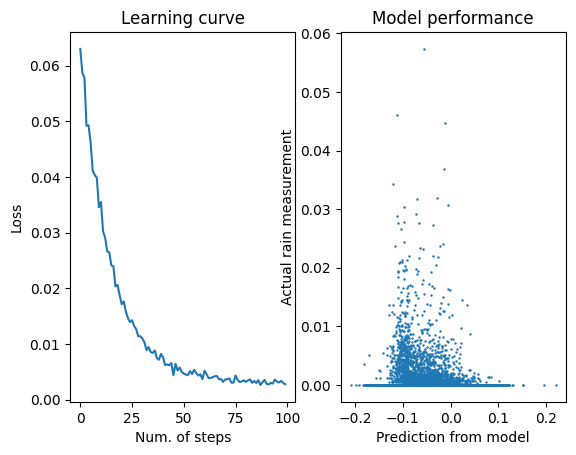

In [8]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


class WeatherDataset(Dataset):
  def __init__(self, train_in, train_out):
        # Initialize data
        self.n_samples = train_in.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = train_in # size [n_samples, n_features]
        self.y_data = train_out # size [n_samples, 1]

  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

  # we can call len(dataset) to return the size
  def __len__(self):
      return self.n_samples

class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b

    def forward(self, x):
        y = self.linear(x)
        return y

def process_csv(filename):
  df = pd.read_csv(filename)

  # Filter data and apply normalization
  df = df.dropna()
  datatensor = torch.tensor(df.values[1:,1::].astype(float))
  datatensor = torch.nn.functional.normalize(datatensor)

  # Randomly select 80% of the examples for training,
  # remaining 20% will be for testing
  train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
  traindata = torch.stack([t for t in train])
  testdata = torch.stack([t for t in test])

  # We can create separate tensors to input and output to the model
  train_in = torch.cat([traindata[:,0:2], traindata[:,3::]], dim=1)
  test_in = torch.cat([testdata[:,0:2], testdata[:,3::]], dim=1)
  train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
  test_out = testdata[:,2].unsqueeze(1)
  return train_in, train_out, test_in, test_out


def train(model, loss, optimizer, \
          trainingData, \
          learning_rate, steps, batch_size):

  loader = iter(DataLoader(dataset=trainingData, batch_size=batch_size, shuffle=True))

  losses = []; step = 0
  for step in range(0, steps):
    input, target = next(loader)
    optimizer.zero_grad() # reset gradiant value to zero
    model.double()
    output = model(input) # pass input to model
    err = loss(output, target) # compute mean squared error between model prediction and target value
    losses.append(err) # store err value to monitor training

    err.backward() # evaluate the gradient
    optimizer.step() # propagate the evaluated gradient to update parameters

    #print('step {}, loss {}'.format(step, err.item()))
  return losses

if __name__ == '__main__':
  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.01
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # ideally need to save the model persistently, not in RAM
  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

## Exercise 1

Using the provided example, plot 9 different plots for the model learning curves by ranging the batchsize in range $\{32, 64, 128\}$, and the learning rate in range $\{0.005, 0.01, 0.05\}$. At each time, observe and comment on how the change of hyperparameter affects different properties of the learning curve (e.g. the shape, the smoothness or sharpness).

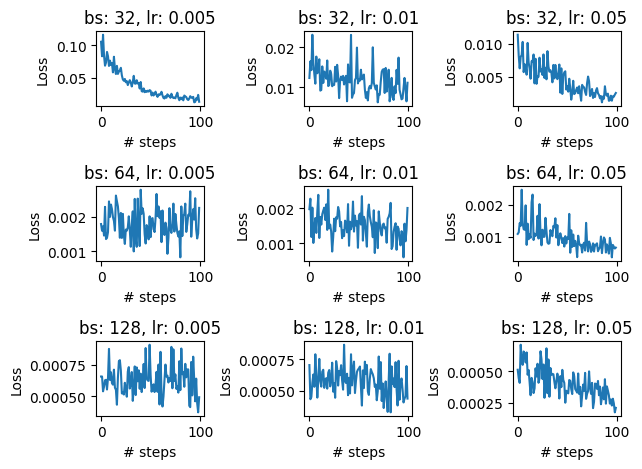

In [7]:
## Solution ##
fig, axs = plt.subplots(3, 3)

def experiment1():

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  steps = 100

  for i, batch_size in enumerate([32, 64, 128]):
    for j, learning_rate in enumerate([0.005, 0.01, 0.05]):
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

      axs[i][j].plot(range(steps), torch.stack(losses).detach())
      axs[i][j].set_title('bs: {}, lr: {}'.format(batch_size, learning_rate))
      axs[i][j].set_xlabel('# steps')
      axs[i][j].set_ylabel('Loss')


  plt.tight_layout()
  plt.show()

experiment1()


## Exercise 2

Implement a Python application for rain prediction in New York City using the data set and provided functions for data processing and linear regression which uses the mean absolute error as the loss function. You may use any PyTorch functions.

Mean absolute error is defined as:

$$
 MAE(x, y) = \frac{1}{n} \sum_{i=1}^n |y_i - x_i|
$$

Plot the prediction vs. actual rain measurement plots for the different models.

**Note**: Each model might have different hypermaparameters optimal for their convergence. You can use the variables $learning_rate$ and $steps$ which are inputs to the training function to tune the optimal training hyperparameters of your regression model.

The min. squared error in training is:  tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)


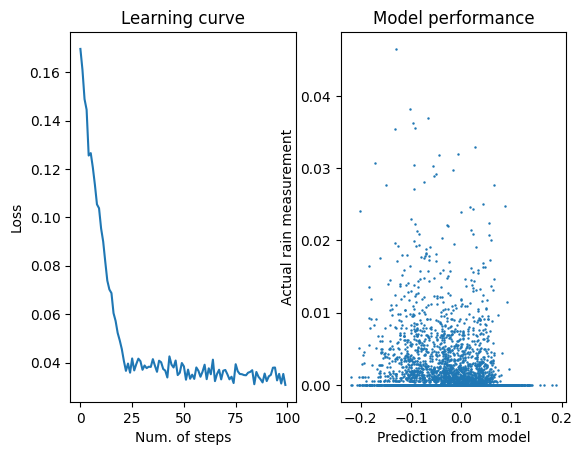

In [9]:
## Solution ##

def experiment2():
  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.005
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  # changed the loss function from MSE to MAE (less variance)
  loss = torch.nn.L1Loss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment2()


## Takes from our initial experiments

### NOTE: How can I change my approach? How can I think again about my problem?

1. If the model by design does not ensure a restriction on the correct range of outputs, there will be no way for the model to learn that range by itself. It will be our job as machine learning scientists to ensure that the design is consistent with the requirements of the target application from every theoretical and practical sense.
2. Repeated runs of the model may yield unstable results of the experimental settings are non-deterministic.
3. There is no one setting that works for every data set and model. Each model and data set will need its own **specific set of optimal hyper-parameters** to learn from that **specific dataset** using that **specific model**.

Rethinking our pipeline, we'll start by addressing the model design. Theoretically, the range of values of the input $x$ and output $y$ of a linear regression model

$$
  y = A*x + b
$$

is the $\mathbb{R}$.

In our application, the rain measurement values are in the range $[0, 1]$ since we have normalized them. In order to inform the model of this restriction, we can extend the model equation with an additional layer using an **activation function**. (**to shift to the probability mapping**)

## Logistic function

A typical function that could restrict the range of values produced by a linear projection module is the **logistic** function which takes a range of real values and transforms them into the range of values in $[0, 1]$.

$$
  \sigma (x) = \frac{e^x}{1 + e^x}
$$

(0.0, 1.0)

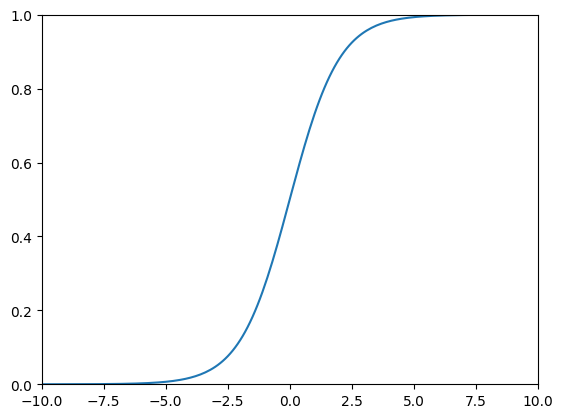

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math

xi = np.arange(-10, 10, 0.1)
y = [ math.exp(x) / (1 + math.exp(x)) for x in xi]

plt.plot(xi, y)
plt.xlim(-10, 10)
plt.ylim(0, 1)


In [16]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        z = self.act(y)
        return z

We can try to test how the output range will now change.

## This one is rather implying that the data is sparse and that the probability of the outcome is close to zero (but this is better than the previous step)

The min. squared error in training is:  tensor(0.0065, dtype=torch.float64, grad_fn=<MseLossBackward0>)


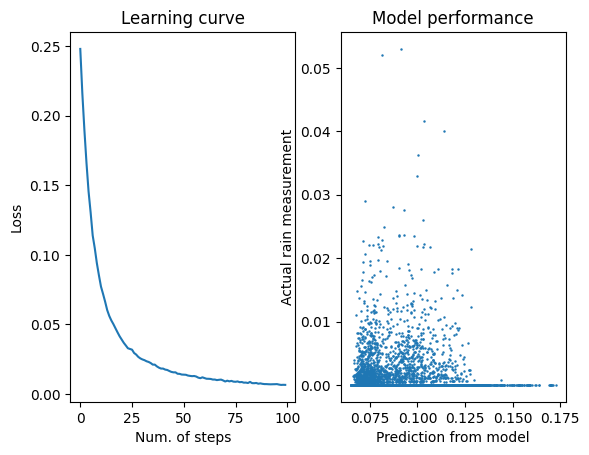

In [17]:
def experiment3():
  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 100
  batch_size = 256

  model = LogisticRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))


  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment3()

Note that our model has only 8 input features, thus, an 8x1 $A$ matrix for predicting the linear projection $y = A*x $ weight of each feature. If we wanted to understand how these features are weighted at each prediction, we could try to visualize their values.

In [20]:
df = pd.read_csv('NYC_Weather_2016_2022.csv')
print(list(df.columns[1:3]) + list(df.columns[4::]))

# let's see what our model has learned by simply printing the weights of the model
print(model.linear.weight)

['temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)']
Parameter containing:
tensor([[-0.2442,  0.0167,  0.0552, -0.0543, -0.2487, -0.2070, -0.1420, -0.0989]],
       dtype=torch.float64, requires_grad=True)


## Classification and Prediction Accuracy

## Regression didn't help much, let's move to the classification problem (it either rains, or not)

A linear model with only 8 parameters may not be able to accurately model a highly complex hypothesis using an imbalanced and sparse data set. In order to ease the complexity of the task we can reduce the complexity to a **classification** task. In this case, we can still try to estimate whether or not it will rain at a given moment using our logistic model.

In [21]:
predictions = torch.where(predictions > 0, 1.0, 0.0)
test_out = torch.where(test_out > 0, 1.0, 0.0)

print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])


Accuracy of prediction is:  tensor(0.4096)



**Accuracy** is the percentage of all correctly classified examples in our test set.  

A more refined analysis can be performed using **the confusion matrix**:
$$
C = \begin{bmatrix}
\text{Predict 0, Actual 0} & \text{Predict 0, Actual 1}\\
\text{Predict 1, Actual 0} & \text{Predict 1, Actual 1}
\end{bmatrix}
$$

Notice that the diagonal entries are the examples that are correctly classified.  

The most useful classification metrics are **Precision** and **Recall**. If we define a prediction $C_{ij}$ which belongs to class i for which we estimated the label i, we calculate them as follows.

#### Precision Score
The precision score is the percentage
$$
\text{Precision}_0 = \frac{C_{00}}{C_{00} + C_{01}}
$$

$$
\text{Precision}_1 = \frac{C_{11}}{C_{11} + C_{10}}
$$
which is the percentage of predicted rain possibility that we classify correctly.  

#### Recall Score
The recall score is the percentage
$$
\textrm{Recall}_0 = \frac{C_{00}}{C_{00} + C_{10}}
$$
$$
\textrm{Recall}_1 = \frac{C_{11}}{C_{11} + C_{01}}
$$
which is the percentage of rain possibility that we classify correctly. Note that Precision and Recall are two different quantities.

**Using multiple evaluation metrics helps give a better picture of how well our classifier is doing.**

## Exercise 1

Using the different features in the weather measurement data set, train an individual logistic regression model on each of the individual measurements:
- 'temperature_2m (°C)'
- 'precipitation (mm)'
- 'cloudcover (%)'
- 'windspeed_10m (km/h)'
- 'winddirection_10m (°)'

Plot the learning curve and predictions for the 5 different models each trained on a different set of measurements.
Calculate the binary rain prediction accuracy, precision and recall.

In [32]:
# DELETE THIS ONCE DONE WITH THE FUNCTION


train_in, train_out, test_in, test_out = process_csv("NYC_Weather_2016_2022.csv", 3)
print(train_in.shape, train_out.shape, test_in.shape, test_out.shape)

torch.Size([47669, 1]) torch.Size([47669, 1]) torch.Size([11917, 1]) torch.Size([11917, 1])


The min. squared error in training is:  tensor(0.0095, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Accuracy of prediction is:  tensor(0.1383)
The min. squared error in training is:  tensor(0.0108, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Accuracy of prediction is:  tensor(0.1364)
The min. squared error in training is:  tensor(0.0108, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Accuracy of prediction is:  tensor(0.1328)
The min. squared error in training is:  tensor(0.0109, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Accuracy of prediction is:  tensor(0.1294)


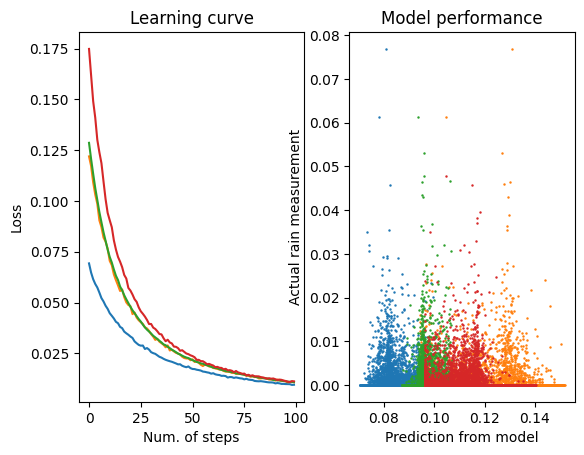

In [38]:
## Your solution ##

# now we process the csv file only with respect to one feature
def process_csv(dataset, col_index):
    ## To-do: Update to return only one-dimensional features
    df = pd.read_csv(dataset)

    # Filter data and apply normalization
    df = df.dropna()
    datatensor = torch.tensor(df.values[1:,1::].astype(float))
    datatensor = torch.nn.functional.normalize(datatensor)

    # Randomly select 80% of the examples for training,
    # remaining 20% will be for testing
    train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
    traindata = torch.stack([t for t in train])
    testdata = torch.stack([t for t in test])

    # We can create separate tensors to input and output to the model
    
    # train_in = torch.cat([traindata[:,0:2], traindata[:,3::]], dim=1)
    train_in = traindata[:, col_index].unsqueeze(1)
    
    # test_in = torch.cat([testdata[:,0:2], testdata[:,3::]], dim=1)
    test_in = testdata[:, col_index].unsqueeze(1)
    
    train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
    test_out = testdata[:,2].unsqueeze(1)
    return train_in, train_out, test_in, test_out
        
    
def exercise1(feature_we_are_interested_in):
  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset, feature_we_are_interested_in)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 100
  batch_size = 256

  model = LogisticRegression(inputSize=1, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

  # To-do: Compute accuracy, precision, recall
  predictions = torch.where(predictions > 0, 1.0, 0.0)
  test_out = torch.where(test_out > 0, 1.0, 0.0)

  print("Accuracy of the prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
  print("Accuracy of the prediction is: "), 
  print("Recall of the prediction is: "), 
    

exercise1(3)
exercise1(4)
exercise1(5)
exercise1(6)

While the activation functions can help refine the range of target output, the ultimate estimation of the underlying function $y = f(x)$ that helps learn the data distribution depends on the loss function. Least squares may help in many prediction tasks, but for predicting the probability of any future event, we can rely on the **cross-entropy** function.

Cross-entropy essentially measures the similarity between two probability distributions. Here, $y$ represents the underlying function we are trying estimate using the data:

$$\mathcal{L}(x,y) = - ( y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+}) )$$

and $p_+$ in our application will represent the predicted probability of observing rain (the positive event) measured using the weather data set.
Note that $p_{+}$ depends on $x$ and the model parameters.


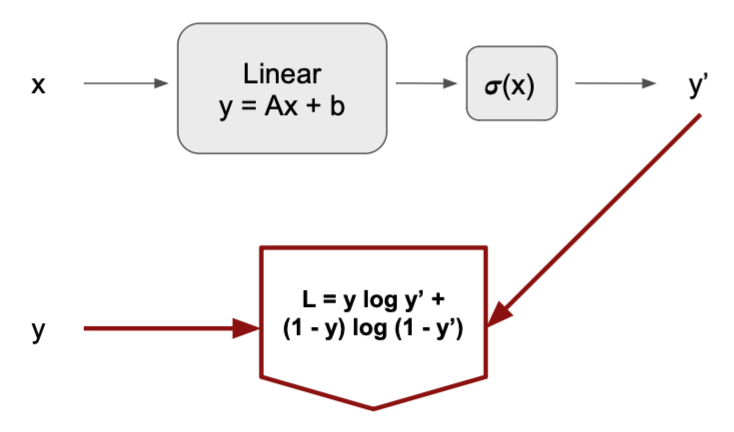


## Exercise 2: Binary Cross-entropy

We can now finalize our logistic regression model with the cross-entropy loss. If we want to predict the probability of rain, now we need to change our target data from rain measurement to binary values representing the presence of rain.

In the next exercise, change the loss function to binary cross-entropy and the output labels to binary values. Plot the learning curve and predictions for the model using all features and display the model weights corresponding to each input feature. Repeat the experiment for the models using individual features. Calculate the accuracy, precision and recall at each case.

In [ ]:
## TO-DO: Replace problem with binary classification and change loss function.
# Repeat experiments and analyze the model.



## Exercise 3: Multi-class classification

In this exercise, we will implement a logistic regression model on multi-class classification. We will use the [Iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) flower data set which contains different physical properties from three related species of Iris flowers collected by Edgar Anderson. It was first used by British statistician and biologist Ronald Fisher in 1936 for his pioneering study on linear discriminant analysis [1].

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg" width="200"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width="200" />
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg" width="200" />
</div>

*Images from Wikipedia.*

[1] Fisher, R.A. “The use of multiple measurements in taxonomic problems” Annual Eugenics, 7, Part II, 179-188 (1936).

We can load the data set automatically using the [sklearn](https://scikit-learn.org/stable/) library.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['target'] = pd.Series(iris_data.target)

df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We can start by doing some analysis. We can write a short analysis code to count how many samples are there from each class of flower and plot the count as a bar graph.

N = 150 data points


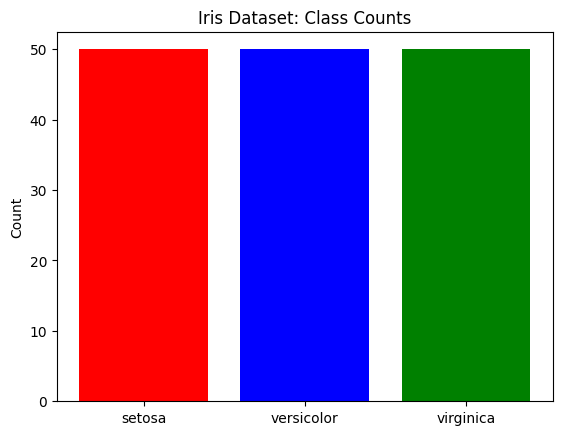

In [ ]:
import matplotlib.pyplot as plt

# Count the number of classes and plot.
N = len(df) # The number of data points.
print('N = {:d} data points'.format(N))

# Give a barplot of each class.
plt.figure()
plt.bar([0,1,2], df['target'].value_counts(ascending = True), color = ['r', 'b', 'g'], tick_label = iris_data.target_names)
plt.ylabel('Count')
plt.title('Iris Dataset: Class Counts');



Next, we will create a training and testing split. Please process the data to convert to tensors and store as training and testing tensors. Make sure the data is numeric and clean. Note that we also need to define the input and output to our classification model.

In [ ]:
import torch

# TO-DO: Repeat data processing to crate training and testing tensors

# Write data processing and splitting routine
df = df.dropna()
datatensor = torch.tensor(df.values)

# Randomly select 80% of the examples for training,
# remaining 20% will be for testing
# We should also separate into input and output to the model

# train_in = ..
# train_out = ...
# test_in = ...
# test_out = ...


# In case of multi-class classification we will reorganize the output to 3 dimensions each representing
# the probability of an individual class
# (represent each class as one-hot vector as in [1,0,0])
#
#

Define again a PyTorch Dataset type class to store and easily iterate over the Iris Data Set.

In [ ]:
# TO-DO: Implement data set class
from torch.utils.data import Dataset, DataLoader, RandomSampler

class IrisDataset(Dataset):
  #
  #

Define a logistic regression model and create a training routine to train the model on the training data. Plot the learning curve. Make sure the training is stable and model converges by tuning the hyperparameters, including the batch size and learning rate.

In [ ]:
# TO-DO: Complete model

class LogisticRegression(torch.nn.Module):
  #

In [ ]:
# Implement the model and create training routine.
def train(model, loss, optimizer, \
          trainingData, \
          learning_rate, steps, batch_size, epochs):



Use the testing set to generate predictions with the model. Calculate the prediction accuracy, precision and recall for each of the three classes.

In [ ]:
# TO-DO

## Further exercises:

- [Google crash course on machine learning](https://developers.google.com/machine-learning/crash-course)
includes visual exercises like [experiments with hyper-parameters](https://developers.google.com/machine-learning/crash-course/fitter/graph)